# "Macroeconomic" Models: the `Market` Class

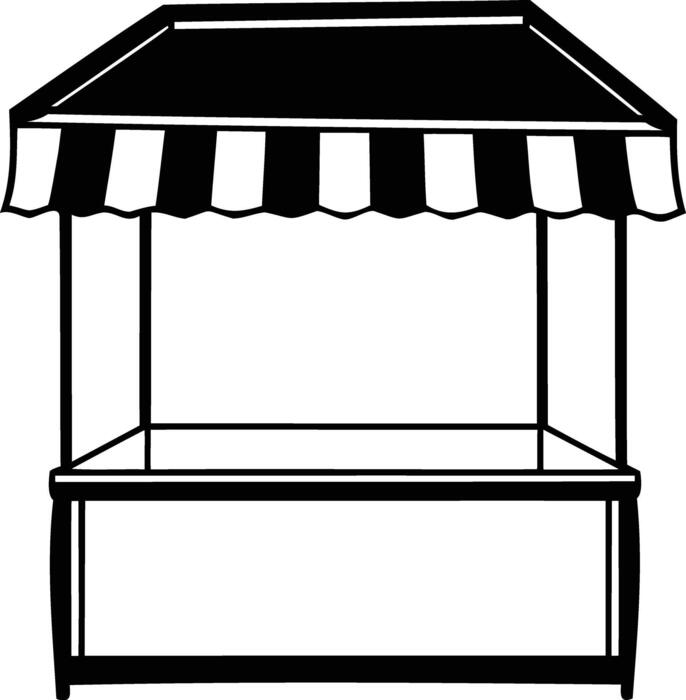

In [1]:
from IPython import display

display.Image("../../docs/images/market_thumbnail.jpg", width=200)

When we refer to a "microeconomic" model in HARK, we mean a problem that pertains to some particular agent-- maybe many agents who all share the same problem. These agents treat the inputs to their problem as exogenously given. This is the essence of an `AgentType` instance: they have some information that characterizes their problem, and they must solve it.

By a "macroeconomic" model, we mean that *some* of the things that individual agents treat as exogenous are actually *endogenous* in aggregate. HARK's framework for solving for an equilibrium with respect to those object is the `Market` class. In principle, the kinds of models for which the `Market` class can find equilibria are not required to be macroeconomic *per se*, hence our use of quotation marks.

## What Do We Mean By "Equilibrium"?

The equilibrium concept for the `Market` class is based on the work of Krusell and Smith in their seminal 1998 paper, but expanded to a generalized (really: generic) context. Consider a triangular mapping among **beliefs**, **behavior**, and **outcomes**:

- Agents have **beliefs** about some economic object(s) of interest. *Conditional on* those beliefs, they solve their microeconomic problem to choose a course of action for any situation they might find themselves in. Thus **beliefs** yield a description of agent **behavior**.
- If we know how all agents will **behave**, then we can simulate a history of micro- and macroeconomic **outcomes**, whatever that means in the mechanical context of the model. That is, given agents' policy functions, how does the world actually "shake out"?
- Finally, if shown a hypothetical set of **outcomes**, the agents have *some way* to interpret them and generate **beliefs** about the economic objects of interest. In some cases, this might be straightforward, like observing the *actual value* that the object took on and adopting that as the belief.

An **equilibrium** is a set of beliefs, behavior, and outcomes that are *internally consistent*: if the agents have these beliefs, then their chosen behavior will yield outcomes that in turn justify those same beliefs.

A special case (so special that it's the standard assumption in economics) is a **rational expectations equilibrium** in which agents' behavior is *optimally* chosen according to their preferences *and* the beliefs that are generated from any outcomes are rational or "the right ones".

In contrast, a model *could* have agents that follow an arbitrary or non-optimal decision rule conditional on their beliefs. Or it could have a way to interpret outcomes into beliefs that is "biased" or incorrect-- or maybe (some of) the agents believe the same thing *no matter the outcomes*.

A closely related special case that is often used in practice is a **boundedly rational equilibrium** in which the agents form beliefs that are *approximately* correct, or that is based on a *simplified* or *restricted* representation of the model.

For example, in Krusell & Smith (1998), the interest and wage rate depend on aggregate capital, which in turn depends on the asset holdings of each individual agent. For any consumer to predict *future* factor prices, they must know how much money *every single person* has, as well as how they will consume. This is an intractable problem, so the authors suppose that individual agents can only observe some limited information about the distribution of wealth-- say, the first one or two moments.

They further restrict their agents to have beliefs about the mapping from current wealth to future capital holdings that have a particular *parametric form*. Technically speaking, *any* parametric restriction (which includes all possible *computationally representable* functions) means that we only have boundedly rational agents. Hence we don't try to draw any firm lines about rational expectations vs boundedly rational.

## How Does HARK Incorporate these Concepts?

In HARK, the mapping from beliefs to behavior is captured by `AgentType` instances running their `solve()` method. Beliefs about the economic objects of interest are given to the agents in the `Market`, and they `solve` their problem based on those beliefs-- whatever that means in context. The various consumption-saving models in HARK all involve agents solving an intertemporal utility maximization problem, but this is not "hardwired" into HARK itself.

The mapping from behavior to outcomes is based on straightforward simulation and is strictly mechanical. The `Market` class uses a farming metaphor to describe the steps of this process, in terms of micro- and macro-level outcomes; see below.

How a history of outcomes generates new beliefs is fully customizable and generic in HARK. As described more below, each `Market` instance has a `calc_dynamics` function that specifies how to generate beliefs from a history of outcomes. (**NB:** We have some regrets about the names of some `Market` attributes, including `calc_dynamics`, and might change them in the future.)

Once a `Market` instance is specified (see below), you can call its `solve()` method to iterate on the "triangular mapping" until convergence. That is, beliefs that induce new beliefs *sufficiently close* to call it "good enough".

### Elements of a `Market`

Depending on your purposes, you can make a subclass of `Market` or simply fill in these attributes of an ordinary instance of `Market`:

- `agents`: A list of `AgentType` instances, representing the participants in this environment.
- `dyn_vars`: A list of strings naming the economic objects for which an equilibrium is sought. Despite the name, these objects need not be numeric variables; they can be generic objects. The `agents`' problem should depend in some way on things named in `dyn_vars`-- they enter their problem *directly* through their `solve_one_period` function and/or *indirectly* through a constructed object that depends on things named in `dyn_vars`.
- `sow_vars`: A list of strings naming things that should be sent *from* the `Market` *to* its `agents` in each period of the simulation, when generating outcomes. These usually represent "macroeconomic" variables that can only be calculated at the aggregate level.
- `reap_vars`: A list of strings naming things that should be collected *from* the `agents` *by* the `Market` in each period of the simulation. These usually represent individual level microeconomic variables that will be aggregated by the `Market`.
- `const_vars`: A list of strings naming things that the `Market` needs to know in order to compute aggregate outcomes from individual outcomes. These might be constant parameters that characterize the `Market`, but is often just an empty list.
- `track_vars`: A list of strings naming aggregate outcomes whose history should be tracked/recorded during simulation. This is often a subset of `sow_vars`.
- `mill_rule`: A function or method that takes as arguments the `reap_vars` and `const_vars` and returns the `sow_vars` (in order!). It represents the processing of individual outcomes into aggregate outcomes, whatever that means in context.
- `calc_dynamics`: A function or method that takes as arguments the histories of aggregate outcomes named in `track_vars` and returns new beliefs about the objects named in `dyn_vars`.
- `act_T`: The number of times that the "aggregate market process" should be run when generating a simulated history. This *usually* corresponds to the number of periods for which the model should be simulated.
- `tolerance`: The maximum acceptable "distance" between successive iterations of beliefs to constitute convergence.

The `Market` class also has a method called `reset()` that specifies how to return it to its initial state, in preparation for a new history run. The default method works for most cases, but can be extended by specifying a `Market` subclass.

### Additional Requirements for `AgentType`s to Participate in a `Market`

Very little needs to be added to an `AgentType` to make it compatible with a `Market`. The two specific methods it needs to have are:

1. `reset()`: Resets the instance to their initial configuration, in preparation to generate a new history. This can often just be a call to `initialize_sim()`, which resets all `AgentType`-side simulation objects.
2. `market_action()`: A method that specifies *what the agents do* during the "market process". This is *usually* just "simulate one period of the model" by calling `simulate(1)`.

The other aspects of compatibility include:

- The `AgentType` uses the objects named in `dyn_vars` *somehow* when they `solve()` their model. If one or more `dyn_vars` enters *indirectly* through a constructed object, then the `pre_solve()` method should include an instruction to `construct()` that attribute.
- The `AgentType` uses the objects named in `sow_vars` *somehow* when they execute their `market_action()`. If not, then there is essentially no communication from the `Market` to its `agents` during simulation (which is possible, but unlikely).
- The `AgentType` generates the objects named in `reap_vars` during their `market_action()`, storing them as attributes of `self` and/or in their `state_now` or `controls` dictionaries. HARK will throw an error if this is not the case-- the `Market` expects to be able to `reap` its harvest!
- The `AgentType` has initial/default values for the `dyn_vars` as a starting guess. These might be centrally distributed by your `Market`.

## How `Market`'s `solve` Method Works

The `Market.solve()` method works on a fairly simple loop on the "triangular mapping"; the `max_loops` attribute limits the number of times the loop will run. Note that the `agents` must already have *some* valid `dyn_vars` already on them before attempting to `solve` (their initial/default beliefs). On each iteration:

1. Each of the `AgentType` instances in `agents` runs their `solve()` method, generating new policy functions / decision rules (etc). By default, HARK tries to parallelize this operation using its `multi_thread_commands` utility.
2. The `Market` resets its `history` and then generates a new one by looping `act_T` times on these steps:
    1. `sow`: Send current values of the `sow_vars` to each of the `agents`.
    2. `cultivate`: Have each of the `agents` execute their `market_action`.
    3. `reap`: Collect the `reap_vars` from each of the `agents`.
    4. `mill`: Execute the `mill_rule` to process the newly `reap`ed information into the next `sow_vars`.
    5. `store`: Record values of the current `track_vars` in the `history`.
3.  Generate new beliefs about `dyn_vars` by passing the `history` of the `track_vars` to `calc_dynamics`.
4.  Give those new beliefs to each of the `agents`.
5.  If this is not the first iteration, calculate the `distance` between new beliefs and prior beliefs.
    - If it is less than the `tolerance`, or `max_loops` iterations have passed, record the final beliefs and exit.
    - Otherwise, go to step (1).

Note that while the description above said that the *agents* update their beliefs based on the history of outcomes, HARK actually does this step at the `Market` level. That is, HARK currently assumes that all of the `agents` have the same way of generating beliefs. While this is the *standard* assumption, we will loosen it in the future to allow each of the `agents` to update their beliefs independently. E.g., perhaps *some* agents generate (boundedly) rational beliefs from a history, but *other* agents have completely fixed, static beliefs.

### Caveats and Notes

There are two aspects of `Market`'s programming that might be surprising on first take:

1. When the `reap_vars` are passed to the `mill_rule`, each one is a *list* with one element from each of the `agents`. In the typical case in which `reap_vars` represent idiosyncratic states or controls (as a `np.array`), the first thing a `mill_rule` should do is to `np.concatenate` each input to combine the data across the `agents`. This is not done automatically because we did not want to assume that the `reap_vars` are always vectors-- or even numbers at all!
2. Due to a poor programming choice early in HARK's existence, `Market` expects that `calc_dynamics` returns an object with the *attributes* named in `dyn_vars`, rather than just the `dyn_vars` themselves. This will be fixed in the near future to permit multiple formats of output.

For a more concrete example of `Market` in action, see the [documentation notebook](../ConsAggShockModel/AggShockConsumerType.ipynb) for `AggShockConsumerType` and its associated `Market` subclasses: `CobbDouglasEconomy` and `SmallOpenEconomy`. (This notebook will be improved and expanded in the near future.)

## Why Does `Market` Exist At All?

You *might* be wondering why the `Market` class exists at all: why can't `Market.solve()` just be part of `AgentType`'s structure (with a different name)? After all, it's just trying to look for beliefs that are consistent with market outcomes.

The answer is simple: We wanted this functionality to work with models *ex ante* heterogeneous agents, e.g. heterogeneous parameters. One of the academic projects that members of the Econ-ARK team were working on when HARK began was "The Distribution of Wealth and the Marginal Propensity to Consume," (Carroll, Slacalek, Tokuoka, and White (2017)). That paper's model involves discount factor heterogeneity-- it discretizes a uniform distribution of $\beta$ with seven points.

The machinery of `Market` and its `agents` attribute is designed to make models like that *easy* and *organized* to specify. We wanted HARK to have the flexibility to incorporate much weirder specifications, including environments with *different kinds* of agents-- their model or behavioral framework differs, not just their parameters.